In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


# Basic Neural Networks

## **Project:** Weather Detection Type and Time of Day on Videofrom Car’s DVR

<b>Done by  : </b> <br/>
Edwin Carreño  <br/>
N. Sitdikova   <br/>
N. Rerikh   <br/>
R. Shakurov   <br/><br/>
<b>Date:</b> 02.11.2020 <br/>
<b>**Institution: Kazan National Research Technical University** </b>


### Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

from os import listdir
from os.path import isfile, join
from keras import backend as K



In [5]:
# Printing libraries versions

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.4.0


Utility functions

In [ ]:
def getTime(startTime, endTime):
    
    """Converts elapsed time in HH:MM:SS format"""
    
    elapsedTime = (endTime - startTime)/3600
    
    hours = int(elapsedTime)
    minutes = int((elapsedTime - hours)*60)
    seconds = round((((elapsedTime - hours)*60) - minutes)*60)
    print("{}:{}:{} --> format HH:MM:SS".format(hours, minutes, seconds))
    #return hours, minutes, seconds
    

def plottingResults(modelName):
    
    print("\n========================================")
    print("=====        Plotting {}         =====".format(modelName.name))
    print("========================================")
    
    
    history_dict = history.history
    print(history_dict.keys())

    acc      = history.history[     'accuracy']
    val_acc  = history.history[ 'val_accuracy']
    loss     = history.history[    'loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1, 1)
 
    
    plt.figure()
    plt.plot(epochs, acc, 'r--', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    
    plt.figure()    
    plt.plot(epochs, loss, 'r--',label='Training loss')
    plt.plot(epochs, val_loss, 'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    #plt.yscale('log')
    plt.legend()

    plt.show()

# Machine Learning Pipeline

 ## 1. Loading Dataset

In [ ]:
# Loading data uploaded in Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Listing files in the Google Drive folder
!ls drive/MyDrive/ColabNotebooks/BNNProject/BNNPROJECT/TrainingDataset/

AfternoonCloudy  EveningClear  MorningCloudy  MorningSunny  NigthRainy
AfternoonRainy	 EveningRainy  MorningRainy   NigthClear


In [ ]:
# Loading data uploaded in Kaggle

# Dimension of the images
img_height = 331
img_width = 331
channels = 3

batch_size = 16

image_size = (img_height, img_width)

data_dir = "drive/MyDrive/ColabNotebooks/BNNProject/BNNPROJECT/TrainingDataset"
target_path = "drive/MyDrive/ColabNotebooks/BNNProject/BNNPROJECT/EarlyDataset/"


data_dir = pathlib.Path(data_dir)

In [ ]:
# Creating a training dataset from the data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    color_mode = 'rgb',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 11380 files belonging to 9 classes.
Using 9104 files for training.


In [ ]:
# Creating a validation dataset from the data

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode='rgb',
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 11380 files belonging to 9 classes.
Using 2276 files for validation.
['AfternoonCloudy', 'AfternoonRainy', 'EveningClear', 'EveningRainy', 'MorningCloudy', 'MorningRainy', 'MorningSunny', 'NigthClear', 'NigthRainy']


### Visualizing some pictures in the dataset

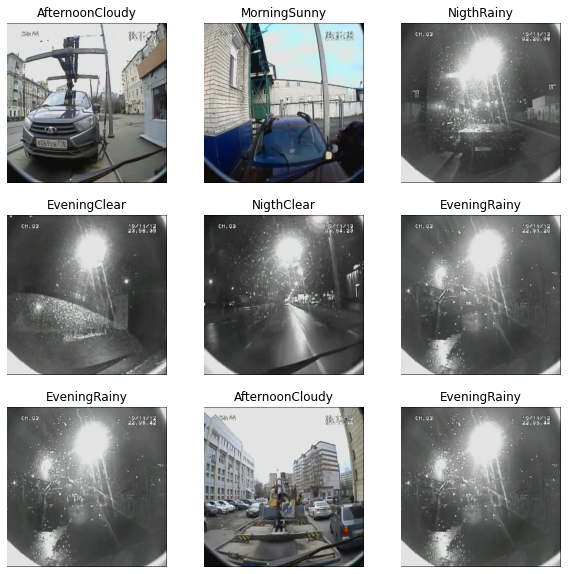

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 331, 331, 3)
(16,)


In [ ]:
labels_batch

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([3, 8, 1, 2, 3, 2, 3, 2, 4, 4, 7, 5, 8, 4, 3, 3], dtype=int32)>

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2. Standarization

In [ ]:
#for image_batch, label_batch in train_ds:
#    image_batch = tf.image.per_image_standardization(
#        image_batch
#    )

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

In [ ]:
#print(image_batch)

In [ ]:
# Number of Classes, total 3 in this case for Cats, Dogs and Pandas
num_classes = len(class_names)

## 3. Modeling

### 3.1 Building Convolutional Neural Networks Architectures
* 1. (2000) AlexNet 
* 2. (2003) VGG16                 
* 3. (2008) Inception-v3      
* 4. (2011) ResNet-50         
* 5. (2013) Xception   
* 6. (2017) Inception ResNets 
* 7. (2019) NASNetLarge       

In [ ]:
input_shape = (img_height, img_width, channels)

#### 3.1.1 AlexNet (from scratch)

In [ ]:
model_AlexNet = tf.keras.Sequential([
                                     #C1
                                     tf.keras.layers.Conv2D(filters=96,
                                                            kernel_size=11,
                                                            strides=4,
                                                            activation='relu',
                                                            input_shape=input_shape),
                                     # Normalization layer
                                     tf.keras.layers.BatchNormalization(),
                                     
                                     #S2
                                     tf.keras.layers.MaxPool2D(pool_size=3, 
                                                               strides=2),
                                     #C3
                                     tf.keras.layers.Conv2D(filters=256,
                                                            kernel_size=5,
                                                            strides=1,
                                                            padding='same',
                                                            activation='relu'),
                                     
                                     # Normalization layer
                                     tf.keras.layers.BatchNormalization(),

                                     #S4
                                     tf.keras.layers.MaxPool2D(pool_size=3,
                                                               strides=2,
                                                               padding='valid'),
                                     #C5
                                     tf.keras.layers.Conv2D(filters=384,
                                                            kernel_size=3,
                                                            strides=1,
                                                            padding='same',
                                                            activation='relu'),
                                     # Normalization layer
                                     tf.keras.layers.BatchNormalization(),

                                     #C6
                                     tf.keras.layers.Conv2D(filters=384,
                                                            kernel_size=3,
                                                            strides=1,
                                                            padding='same',
                                                            activation='relu'),
                                     # Normalization layer
                                     tf.keras.layers.BatchNormalization(),

                                     #C7
                                     tf.keras.layers.Conv2D(filters=256,
                                                            kernel_size=3,
                                                            strides = 1, 
                                                            padding='same',
                                                            activation='relu'),
                                     # Normalization layer
                                     tf.keras.layers.BatchNormalization(),
                                     
                                     #S8
                                     tf.keras.layers.MaxPool2D(pool_size=3,
                                                               strides=2),
                                     #Flattening previous layers
                                     tf.keras.layers.Flatten(),

                                     #FD9
                                     tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
                                     
                                     #Dropout layer 1
                                     tf.keras.layers.Dropout(0.2),

                                     #FD10
                                     tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
                                     
                                     #Dropout layer 2
                                     tf.keras.layers.Dropout(0.5),

                                     #Output Layer
                                     tf.keras.layers.Dense(num_classes, activation='softmax')
], name="AlexNet")

print("Architecture Implemented")

#### 3.1.2 VGG16 (from Keras Application)

In [ ]:
model_VGG16 = tf.keras.Sequential(name="VGG16")

model_VGG16.add(
    tf.keras.applications.VGG16(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = input_shape)
)
model_VGG16.add(layers.Flatten())
model_VGG16.add(layers.Dropout(0.5))
model_VGG16.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))

print("Architecture Implemented")

#### 3.1.3 Inception-v3

In [ ]:
model_InceptionV3 = tf.keras.Sequential(name="InceptionV3")

model_InceptionV3.add(
    tf.keras.applications.InceptionV3(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = input_shape)
)
model_InceptionV3.add(layers.Flatten())
model_InceptionV3.add(layers.Dropout(0.5))
model_InceptionV3.add(layers.Dense(num_classes, activation='softmax'))

print("Architecture Implemented")

#### 3.1.4 ResNet-50v2 (from Keras Application)

In [ ]:
model_ResNet50V2 = tf.keras.Sequential(name="ResNet-50V2")

model_ResNet50V2.add(
    tf.keras.applications.ResNet50V2(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = input_shape)
)
model_ResNet50V2.add(layers.Flatten())
model_ResNet50V2.add(layers.Dropout(0.5))
model_ResNet50V2.add(layers.Dense(num_classes, activation='softmax'))

print("Architecture Implemented")

#### 3.1.5 Xception (from Keras Application)

In [ ]:
model_Xception = tf.keras.Sequential(name="Xception")

model_Xception.add(
    tf.keras.applications.Xception(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = input_shape)
)
model_Xception.add(layers.Flatten())
model_Xception.add(layers.Dropout(0.5))
model_Xception.add(layers.Dense(num_classes, activation='softmax'))

print("Architecture Implemented")

#### 3.1.6 Inception ResNet (from Keras Application)

In [ ]:
model_InceptionResNetV2 = tf.keras.Sequential(name="InceptionResNetV2")

model_InceptionResNetV2.add(
    tf.keras.applications.InceptionResNetV2(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = input_shape)
)
model_InceptionResNetV2.add(layers.Flatten())
model_InceptionResNetV2.add(layers.Dropout(0.5))
model_InceptionResNetV2.add(layers.Dense(num_classes, activation='softmax'))

print("Architecture Implemented")

#### 3.1.7 NASNetLarge(from Keras Application)

In [ ]:
"""
model_NASNetLarge = tf.keras.Sequential(name="NASNetLarge")

model_NASNetLarge.add(
    tf.keras.applications.NASNetLarge(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = input_shape)
)
model_NASNetLarge.add(layers.Flatten())
model_NASNetLarge.add(layers.Dropout(0.5))
model_NASNetLarge.add(layers.Dense(num_classes, activation='softmax'))

print("Architecture Implemented")

"""



### 3.2 Configuring Optimizers

#### 3.2.1 AlexNet (from Scratch)  --> Optimizer

In [ ]:
optimizerAlexNet = tf.keras.optimizers.Adam(epsilon = 0.1)

model_AlexNet.compile(
    optimizer = optimizerAlexNet,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model_AlexNet.summary()

print("Optimizer Implemented")

#### 3.2.2 VGG16 (from Keras Applications)  --> Optimizer

In [ ]:
optimizerVGG16 = tf.keras.optimizers.Adam(epsilon = 0.1)

model_VGG16.compile(
    optimizer = optimizerVGG16,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_VGG16.summary()

print("Optimizer Implemented")

#### 3.2.3 Inception-v3 (from Keras Applications) --> Optimizer

In [ ]:
optimizerInceptionV3 = tf.keras.optimizers.Adam(epsilon = 0.1)

model_InceptionV3.compile(
    optimizer = optimizerInceptionV3,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_InceptionV3.summary()

print("Optimizer Implemented")

#### 3.2.4 ResNet-50v2 (from Keras Application)  --> Optimizer

In [ ]:
optimizerResNet50V2 = tf.keras.optimizers.Adam(epsilon = 0.1)

model_ResNet50V2.compile(
    optimizer = optimizerResNet50V2,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_ResNet50V2.summary()

print("Optimizer Implemented")

#### 3.2.5 Xception (from Keras Application) --> Optimizer

In [ ]:
optimizerXception = tf.keras.optimizers.Adam(epsilon = 0.1)

model_Xception.compile(
    optimizer = optimizerXception,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_Xception.summary()

print("Optimizer Implemented")

#### 3.2.6 Inception ResNet (from Keras Application) --> Optimizer

In [ ]:
optimizerInceptionResNetV2 = tf.keras.optimizers.Adam(epsilon = 0.1)

model_InceptionResNetV2.compile(
    optimizer = optimizerInceptionResNetV2,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_InceptionResNetV2.summary()

print("Optimizer Implemented")

#### 3.2.7 NASNetLarge(from Keras Application) --> Optimizer

In [ ]:
"""
optimizerNASNetLarge = tf.keras.optimizers.Adam(epsilon = 0.1)

model_NASNetLarge.compile(
    optimizer = optimizerNASNetLarge,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_NASNetLarge.summary()

print("Optimizer Implemented")
"""

### 3.3 Configuring Additional Parameters


In [ ]:
models = [model_AlexNet,
         model_VGG16,
         model_InceptionV3,
         model_ResNet50V2,
         model_Xception,
         model_InceptionResNetV2
]

epochs = 5
batch_size = 4

## 4. Training 

In [ ]:
for model in models:
    start = time.time()

    history = model.fit(
      train_ds,
      validation_data = val_ds,
      epochs = epochs
    )

    end = time.time()
    getTime(start, end)
    plottingResults(model)
    
    K.clear_session()
    

In [ ]:
ls

In [ ]:
#models = [model_AlexNet]

for model in models:
    start = time.time()

    history = model.fit(
      train_ds,
      validation_data = val_ds,
      epochs = epochs
    )

    end = time.time()
    getTime(start, end)
    plottingResults(model)
    
    K.clear_session()

## 5. Prediction

In [ ]:



onlyfiles = [f for f in listdir(target_path) if isfile(join(target_path, f))]
onlyfiles.sort()
print(onlyfiles)


In [ ]:
def predictions(modelName):
    
    for cat in onlyfiles:
        path = target_path + cat
        print(path)

        img = tf.keras.preprocessing.image.load_img(
            path,
            target_size=(img_height, img_width)
        )
        
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = modelName.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f}% confidence.\n"
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )

In [ ]:
for model in models:
    
    print("\n==========================================================")
    print("=====        Plotting {}         ".format(model.name))
    print("==========================================================")
    
    predictions(model)
    

## End of the Notebook!